In [41]:
import os
from pprint import pprint

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

from tqdm import tqdm

In [42]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
df_train = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
df_train

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [43]:
# 타겟 변수 인코딩
df_train['target_encoded'] = df_train['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)

In [44]:
# 모든 피처 사용
all_features = df_train.drop(columns=['target', 'target_encoded']).columns

In [45]:
# X와 y 정의
X = df_train[all_features]
y = df_train['target_encoded']

In [46]:
# 범주형 및 수치형 피처 분리
categorical_features = X.select_dtypes(include=['object']).columns
numeric_features = X.select_dtypes(exclude=['object']).columns

In [47]:
# 파이프라인 구성 (수치형: 표준화, 범주형: One-Hot 인코딩)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # 결측값 처리
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # 결측값 처리
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [48]:
# ColumnTransformer를 통해 수치형 및 범주형 피처를 변환
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [49]:
# 데이터를 전처리 (One-Hot 인코딩 및 표준화 적용)
X_processed = preprocessor.fit_transform(X)

In [23]:
# TruncatedSVD 적용 (다양한 n_components 값에 대해 분산 비율 계산)
explained_variance_ratios = []
components_range = range(1, min(300, X_processed.shape[1] + 1), 10)  # 10단위로 최대 300까지 테스트

for n in components_range:
    svd = TruncatedSVD(n_components=n, random_state=42)
    svd.fit(X_processed)
    explained_variance_ratios.append(svd.explained_variance_ratio_.sum())

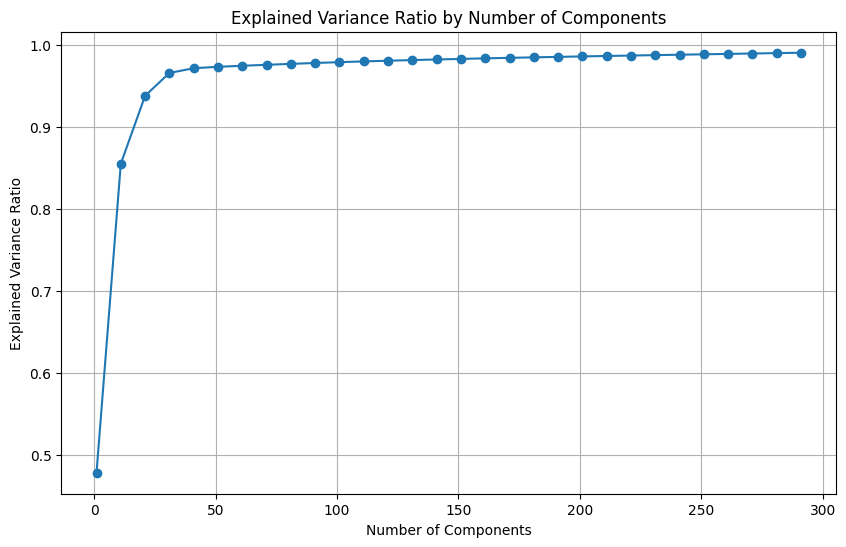

In [24]:
# 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(components_range, explained_variance_ratios, marker='o')
plt.title('Explained Variance Ratio by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

In [50]:
# TruncatedSVD 구성
svd = TruncatedSVD(n_components=50)  # 사용할 주성분 개수 설정 (조정 가능)

In [54]:
# SVM 모델 파이프라인 구성 (TruncatedSVD 포함)
svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('svd', svd),
                               ('classifier', SVC(kernel='rbf', class_weight='balanced', random_state=42))])

In [55]:
# 데이터 분할 (학습용: 80%, 테스트용: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
# SVM 모델 학습
svm_pipeline.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Insp. Seq No._Dam', 'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION X Unit Time_Dam',
       'CURE END POSITION X Judge Value_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Z Unit Time_D...
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
       'Wip Line_Fill2', 'Process Desc._Fill2', 'Equipment_Fill2',
       'Model.Suffix_Fill2', 'Workorder_Fill2', 'Insp Judge Code_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
       'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'],
      dtype='object'))])),
                ('svd', TruncatedSVD(n_components=50)),
                ('classifier', SVC(class_weight='balanced', random_state=42))])

In [58]:
y_pred = svm_pipeline.predict(X_test)

In [59]:
# 성능 평가
print(f"Original number of features: {X.shape[1]}")
print(f"Reduced number of features after TruncatedSVD: {svd.n_components}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Original number of features: 463
Reduced number of features after TruncatedSVD: 50
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      7632
           1       0.08      0.53      0.15       470

    accuracy                           0.64      8102
   macro avg       0.52      0.59      0.46      8102
weighted avg       0.91      0.64      0.73      8102

[[4922 2710]
 [ 220  250]]


In [60]:
df_test = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [61]:
# 모든 피처 사용
X_test = df_test[all_features]

In [62]:
test_pred = svm_pipeline.predict(X_test)

In [63]:
test_pred_labels = ['AbNormal' if y == 1 else 'Normal' for y in test_pred]

test_pred_labels

['AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'AbNormal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',

In [64]:
test_pred_series = pd.Series(test_pred_labels)
count_labels = test_pred_series.value_counts()

print(count_labels)

Normal      10791
AbNormal     6570
Name: count, dtype: int64


In [65]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred_labels

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)